## Set up Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
WORKSPACE_DRIVE_PATH = "/content/gdrive/MyDrive/HGR - Akkodis"

## Import Libraries

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import functools

## 📦 Data

In [ ]:
N_SIGNS = 250
ROWS_PER_FRAME = 543

### Landmarks

In [ ]:
FACE_N_LANDMARKS = 468
HAND_N_LANDMARKS = 21
POSE_N_LANDMARKS = 33
SET_LANDMARKS = [f"face-{i:03d}" for i in range(FACE_N_LANDMARKS)] + [f"left_hand-{i:03d}" for i in range(HAND_N_LANDMARKS)] + [
        f"pose-{i:03d}" for i in range(POSE_N_LANDMARKS)] + [
        f"right_hand-{i:03d}" for i in range(HAND_N_LANDMARKS)]

len(SET_LANDMARKS)

In [ ]:
# Set constants and pick important landmarks : drop most of the face mesh + all others landmarks
LANDMARK_IDX = [0,9,11,13,14,17,117,118,119,199,346,347,348] + list(range(468,543))

print(f"Number of landmarks : {len(LANDMARK_IDX)}")
print(f"Percentage : {len(LANDMARK_IDX)/ROWS_PER_FRAME*100:.2f}%")
print(f"Landmarks : {[SET_LANDMARKS[i] for i in LANDMARK_IDX]}")

<img src="images/pose_tracking_full_body_landmarks.png" alt="pose_landmarks" width="500">

<img src="images/hand_landmarks.png" alt="hand_landmarks" width="500">

<br>
<img src="images/face_landmarks.png" alt="face_landmarks" width="400">

### Load (tf.Dataset)

To keep it simple, we will use the preprocessed tf.Dataset from tfdataset-of-google-isl-recognition-data.

In [ ]:
PATH_DOWNLOAD = f"{WORKSPACE_DRIVE_PATH}/GoogleISLDatasetBatched"

TFDATASET_PATH = f"{WORKSPACE_DRIVE_PATH}/landmark_files_preprocessed__xy__ids_all__val_0.1"

TRAIN_TFDATASET_PATH = f"{TFDATASET_PATH}/trainDataset"
VAL_TFDATASET_PATH = f"{TFDATASET_PATH}/valDataset"
META_TFDATASET_PATH = f"{TFDATASET_PATH}/metadata.json"

# load json
with open(META_TFDATASET_PATH, "r") as f:
    metadata = json.load(f)

print(metadata.keys())
for meta in ["data_columns", "batch_size","val_size"]:
    print(meta,metadata[meta])

N_DATA_COLUMNS = len(metadata["data_columns"])
BATCH_SIZE = metadata["batch_size"]

In [ ]:
def preprocess(ragged_batch : tf.RaggedTensor, labels : tf.Tensor):
    # we only keep the landmarks we are interested in (see LANDMARK_IDX)
    # tf.gather : Gather slices from ragged_batch along axis axis according to indices.
    ragged_batch = tf.gather(ragged_batch, # shape = (N_SIGNS, ROWS_PER_FRAME, 3 or 2)
                             LANDMARK_IDX, # shape = (N_LANDMARKS,)
                             axis=2)

    # remove NaNs and replace them with zeros
    ragged_batch = tf.where(tf.math.is_nan(ragged_batch), tf.zeros_like(ragged_batch), ragged_batch)
    return tf.concat([ragged_batch[...,i] for i in range(N_DATA_COLUMNS)],-1), labels

CHOOSE_GOOGLE_DATASET = False
if CHOOSE_GOOGLE_DATASET:
    dataset = tf.data.Dataset.load(PATH_DOWNLOAD)
    print(f"* Shape before preprocess : { dataset.element_spec[0].shape}")
    N_DATA_COLUMNS = dataset.element_spec[0].shape[-1]
    dataset = dataset.map(preprocess)
    print(f"* Shape after preprocess : { dataset.element_spec[0].shape}")
    print()

    # get cardinality
    VAL_SIZE_PERCENTAGE = 0.1
    DS_CARDINALITY = tf.data.experimental.cardinality(dataset).numpy()
    VAL_HEAD = int(DS_CARDINALITY * VAL_SIZE_PERCENTAGE)

    val_ds = dataset.take(VAL_HEAD).cache().prefetch(tf.data.AUTOTUNE)
    train_ds = dataset.skip(VAL_HEAD).cache().shuffle(20).prefetch(tf.data.AUTOTUNE)

    # todo get batch size, n_data_columns
    N_DATA_COLUMNS = 3

else:
    train_ds = tf.data.Dataset.load(TRAIN_TFDATASET_PATH)
   
    print(f"* Shape before preprocess : { train_ds.element_spec[0].shape}")
    N_DATA_COLUMNS = train_ds.element_spec[0].shape[-1]
    train_ds = train_ds.map(preprocess)#.shuffle(20)
    print(f"* Shape after preprocess : { train_ds.element_spec[0].shape}")
    print()

    val_ds = tf.data.Dataset.load(VAL_TFDATASET_PATH)
    val_ds = val_ds.map(preprocess)

DS_TRAIN_CARDINALITY : int = tf.data.experimental.cardinality(train_ds).numpy()
DS_VAL_CARDINALITY : int = tf.data.experimental.cardinality(val_ds).numpy()

print(f"* Train dataset cardinality : {DS_TRAIN_CARDINALITY}")
print(f"* Validation dataset cardinality : {DS_VAL_CARDINALITY}")
print(f"* Number of data columns : { N_DATA_COLUMNS}")

- `prefetch` is used to load the next batch while the current one is being processed. `tf.data.AUTOTUNE` is used to let tensorflow decide how many batches to prefetch.
- `cache` is used to cache the dataset in memory. This is useful when the dataset is too big to fit in memory.
- `shuffle` is used to shuffle the dataset.


## Model Building

Now let us get to the fun part, training the model!

In [10]:
# include early stopping and reducelr
def get_callbacks():
    """
    Returns a list of callbacks to be used during training.
    - EarlyStopping : stops training when a monitored metric has stopped improving.
    - ReduceLROnPlateau : reduces learning rate when a metric has stopped improving.
    """
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience = 10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor = 0.5,
            patience = 3
        ),
    ]

# a single dense block followed by a normalization block and relu activation
def dense_block(units, name):
    fc = tf.keras.layers.Dense(units)
    norm = tf.keras.layers.LayerNormalization() # normalize the output of the dense layer
    act = tf.keras.layers.Activation("relu")
    drop = tf.keras.layers.Dropout(0.1)
    return lambda x: drop(act(norm(fc(x))))

# the lstm block with the final dense block for the classification
def classifier(lstm_units):
    lstm = tf.keras.layers.LSTM(lstm_units)
    out = tf.keras.layers.Dense(N_SIGNS, activation="softmax")
    return lambda x: out(lstm(x))

In [15]:
# choose the number of nodes per layer
encoder_units = [512, 256] # tune this
lstm_units = 250 # tune this

#define the inputs (ragged batches of time series of landmark coordinates)
inputs = tf.keras.Input(shape=(None,N_DATA_COLUMNS*len(LANDMARK_IDX)), ragged=True)
# ragged tensor is a tensor with variable length rows
# 3*len(LANDMARK_IDX) because todo : je comprends pas

# dense encoder model
x = inputs
for i, n in enumerate(encoder_units):
    x = dense_block(n, f"encoder_{i}")(x)

# classifier model
out = classifier(lstm_units)(x)
model_name = f"lstm_{lstm_units}_encoder_{'_'.join([str(n) for n in encoder_units])}"

model = tf.keras.Model(inputs=inputs, outputs=out,name=model_name)
model.summary()

Model: "lstm_250_encoder_512_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 176)]       0         
                                                                 
 dense_3 (Dense)             (None, None, 512)         90624     
                                                                 
 layer_normalization_2 (Laye  (None, None, 512)        1024      
 rNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, None, 512)         0         
                                                                 
 dropout_2 (Dropout)         (None, None, 512)         0         
                                                                 
 dense_4 (Dense)             (None, None, 256)         131328    
                                          

In [26]:
[steps_per_epoch * n for n in [30,50,70]]

[6990, 11650, 16310]

In [16]:
# add a decreasing learning rate scheduler to help convergence
steps_per_epoch = DS_TRAIN_CARDINALITY
boundaries = [steps_per_epoch * n for n in [30,50,70]]
values = [1e-3,1e-4,1e-5,1e-6]

lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values) # PiecewiseConstantDecay : decay the learning rate at discrete intervals
optimizer = tf.keras.optimizers.Adam(lr_sched)
f
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])

Le taux d'apprentissage (**learning rate**) est un hyperparamètre crucial dans les réseaux de neurones qui détermine l'ampleur de la modification des poids à chaque étape de l'entraînement. En d'autres termes, c'est la quantité par laquelle les poids sont ajustés en réponse à l'erreur calculée lors de la rétropropagation de l'erreur.

- Un taux d'apprentissage **trop élevé** peut entraîner une divergence du modèle et une incapacité à converger vers une solution optimale.
- Un taux d'apprentissage **trop faible** peut ralentir le processus d'apprentissage et prendre beaucoup plus de temps pour atteindre une solution optimale.

Choisir le bon taux d'apprentissage est donc un compromis délicat et souvent expérimental qui doit être ajusté pour chaque problème de modélisation spécifique.

C'est pourquoi des méthodes de planification de taux d'apprentissage telles que PiecewiseConstantDecay sont souvent utilisées pour aider à optimiser ce paramètre en cours d'entraînement ; pour une meilleure convergence et une meilleure précision dans l'entraînement du réseau de neurones. `PiecewiseConstantDecay` est une classe qui décroît le taux d'apprentissage à des intervalles de temps prédéfinis. 

Dans ce code, il est utilisé pour créer un taux d'apprentissage décroissant pour l'optimiseur Adam : il réduit le taux d'apprentissage en utilisant une liste de valeurs fixes à des moments spécifiques de l'entraînement. Sans cette méthode de planification de taux d'apprentissage, le réseau de neurones utiliserait un taux d'apprentissage constant pendant toute la durée de l'entraînement.

### Training

In [17]:
def plot_learning_curves(history, title=""):
    acc      = history.history["accuracy"]
    loss     = history.history["loss"]
    val_acc  = history.history["val_accuracy"]
    val_loss = history.history["val_loss"]
    epochs = range(len(acc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    fig.suptitle(title, fontsize="x-large")

    ax1.plot(epochs, acc, label="Entraînement")
    ax1.plot(epochs, val_acc, label="Validation")
    ax1.set_title("Accuracy - Données entraînement vs. validation.")
    ax1.set_ylabel("Accuracy (%)")
    ax1.set_xlabel("Epoch")
    ax1.legend()

    ax2.plot(epochs, loss, label="Entraînement")
    ax2.plot(epochs, val_loss, label="Validation")
    ax2.set_title("Perte - Données entraînement vs. validation.")
    ax2.set_ylabel('Perte')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    fig.show()

In [18]:
# fit the model with 100 epochs iteration
history = model.fit(train_ds,
          validation_data = val_ds,
          callbacks = get_callbacks(),
          epochs = 10)
# todo : papasaer bc de temps, voir d'autre models, colab

Epoch 1/5
233/233 [==============================] - 136s 532ms/step - loss: 5.3598 - accuracy: 0.0101 - sparse_top_k_categorical_accuracy: 0.0464 - val_loss: 5.3624 - val_accuracy: 0.0154 - val_sparse_top_k_categorical_accuracy: 0.0696 - lr: 0.0010
Epoch 2/5
233/233 [==============================] - 87s 372ms/step - loss: 4.8685 - accuracy: 0.0362 - sparse_top_k_categorical_accuracy: 0.1317 - val_loss: 4.9359 - val_accuracy: 0.0400 - val_sparse_top_k_categorical_accuracy: 0.1332 - lr: 0.0010
Epoch 3/5
233/233 [==============================] - 84s 360ms/step - loss: 4.6031 - accuracy: 0.0608 - sparse_top_k_categorical_accuracy: 0.1976 - val_loss: 4.6651 - val_accuracy: 0.0603 - val_sparse_top_k_categorical_accuracy: 0.1899 - lr: 0.0010
Epoch 4/5
233/233 [==============================] - 113s 479ms/step - loss: 4.3800 - accuracy: 0.0820 - sparse_top_k_categorical_accuracy: 0.2496 - val_loss: 4.6607 - val_accuracy: 0.0646 - val_sparse_top_k_categorical_accuracy: 0.2056 - lr: 0.0010
Ep

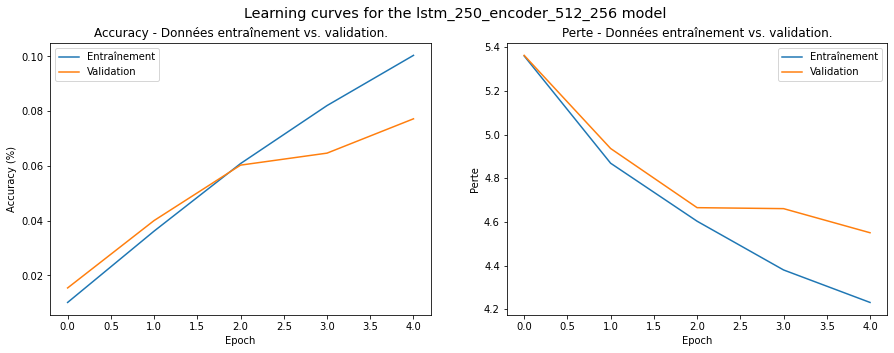

In [19]:
plot_learning_curves(history, title=f"Learning curves for the {model_name} model")

## Inference Test

In [27]:
model.summary(expand_nested=True) # expand_nested : show the layers of the model

Model: "lstm_250_encoder_512_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 176)]       0         
                                                                 
 dense_3 (Dense)             (None, None, 512)         90624     
                                                                 
 layer_normalization_2 (Laye  (None, None, 512)        1024      
 rNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, None, 512)         0         
                                                                 
 dropout_2 (Dropout)         (None, None, 512)         0         
                                                                 
 dense_4 (Dense)             (None, None, 256)         131328    
                                          

In [51]:
def get_inference_model(model):
    """
    Returns a model that takes in a batch of frames and outputs a batch of predictions.
    """
    inputs = tf.keras.Input(shape=(ROWS_PER_FRAME,N_DATA_COLUMNS), name="inputs")

    # drop most of the face mesh
    x = tf.gather(inputs, LANDMARK_IDX, axis=1)

    # fill nan
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

    # flatten landmark xyz coordinates () # todo : for xy coordinates
    x = tf.concat([x[...,i] for i in range(N_DATA_COLUMNS)], -1)

    x = tf.expand_dims(x,0) # add batch dimension (ba batch is a set of frames)

    # call trained model
    out = model(x)

    # explicitly name the final (identity) layer for the submission format
    out = tf.keras.layers.Activation("linear", name="outputs")(out)

    inference_model = tf.keras.Model(inputs=inputs, outputs=out)
    inference_model.compile(loss="sparse_categorical_crossentropy",
                            metrics="accuracy")
    return inference_model

inference_model = get_inference_model(model)
inference_model.summary(expand_nested=True)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 2)]     0           []                               
                                                                                                  
 tf.compat.v1.gather_14 (TFOpLa  (None, 88, 2)       0           ['inputs[0][0]']                 
 mbda)                                                                                            
                                                                                                  
 tf.math.is_nan_14 (TFOpLambda)  (None, 88, 2)       0           ['tf.compat.v1.gather_14[0][0]'] 
                                                                                                  
 tf.zeros_like_14 (TFOpLambda)  (None, 88, 2)        0           ['tf.compat.v1.gather_14[0

## Submit Model

Now it is time to submit. In this competition, we should submit the model itself.

In [53]:
# save the model
for model_path, mdl in zip([f"{WORKSPACE_DRIVE_PATH}/inference_model__{model.name}.tflite", f"{WORKSPACE_DRIVE_PATH}/model__{model.name}.tflite"], [inference_model, model]):
    converter = tf.lite.TFLiteConverter.from_keras_model(mdl)
    tflite_model = converter.convert()
    # submit the model
    with open(model_path, 'wb') as f:
        f.write(tflite_model)